**Problem 1(e)**

In [76]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

#initializing the class for carrying out Barycentric interpolation
class BaryInterp(object):
  def __init__(self,x,f):
    self.x = x  #the nodes
    self.f = f  #the values of functions at the nodes
    self.weights = np.zeros(len(x))  #arroay of the weight for jth node
    self.calc_weights()
    
  ##works on the lower trapezoidal matrix
  def update(self,x_update,f_update):
    self.x = np.append(self.x, x_update)
    self.f = np.append(self.f, f_update)
        
    extra_weights = np.ones([len(self.x),len(self.x)])
    final_multiply = np.ones([len(self.x)])
    final_multiply[:len(self.weights)] = self.weights
    
    
    for i in range(len(self.x)-len(x_update),len(self.x)):
        extra_weights[i,:i] = self.x[:i] - self.x[i]  #filling in sub-diagonal entries
        extra_weights[i,i] = ((-1)**i)*np.prod(extra_weights[i,:i])
    
    extra_weights[len(self.x)-1,:] = np.prod(extra_weights,axis=0)
    self.weights = (1.0/extra_weights)[-1,:]  #final form for the N-th row
    
    self.weights *= final_multiply  #multiplying out by the earlier weights
    
    
  #function to calculate the weights  
  def calc_weights(self):
    N = len(self.x)
    W = np.ones([N,N])
    for i in range(1,len(self.x)):
        W[i,:i] = self.x[:i] - self.x[i]  #filling in sub-diagonal entries
        W[i,i] = ((-1)**i)*np.prod(W[i,:i])
    
    W[N-1,:] = np.prod(W,axis=0)
    self.weights = (1.0/W)[-1,:]  #final form for the N-th row
    
  #function to carry out the Lagrange interpolation   
  def interp_lagrange(self,x_arg):  #x_arg is the set of new points where we want to interpolate
    
    interp_eval = np.zeros(len(x_arg))
    
    for i in range(len(x_arg)):    
        if(np.amin(np.abs(x_arg[i] - self.x)) == 0): interp_eval[i] = self.f[np.argmin(np.abs(x_arg[i] - self.x))]
        else: interp_eval[i] += np.sum((self.weights[:]*self.f[:]/(x_arg[i] - self.x[:])))/np.sum((self.weights[:]/(x_arg[i] - self.x[:])))
    return interp_eval


**Checking update() Method**

In [79]:
import numpy as np
import numpy.polynomial.chebyshev as cheb

nodes1 = np.linspace(-1,1,5) #domains includes -1 and +1 with 5 eqi-spaced nodes

p = np.poly1d([1,2,3,4,5])  #the polynomial f(x) = x^4 + 2x^3 + 3x^2 + 4x + 5

b1 = BaryInterp(nodes1,p(nodes1))  #equispaced

b1.calc_weights()
print("Nodes 1: ",b1.x)
print("Weights 1: ",b1.weights)


nodes2 = np.linspace(-1,1,3) #domains includes -1 and +1 with 5 eqi-spaced nodes

b2 = BaryInterp(nodes2,p(nodes2))  #equispaced

b2.calc_weights()
print("Nodes 1: ",b2.x)
print("Weights 1: ",b2.weights)

x = np.array([-0.5, 0.5])

print("Adding the nodes: ", x)

b2.update(x, p(x))
print("New nodes: ",b2.x)
print("New weights: ",b2.weights)

Nodes 1:  [-1.  -0.5  0.   0.5  1. ]
Weights 1:  [ 0.66666667 -2.66666667  4.         -2.66666667  0.66666667]
Nodes 1:  [-1.  0.  1.]
Weights 1:  [ 0.5 -1.   0.5]
Adding the nodes:  [-0.5  0.5]
New nodes:  [-1.   0.   1.  -0.5  0.5]
New weights:  [ 0.66666667  4.          0.66666667 -2.66666667 -2.66666667]


From the above code snippet we see the following:
* First we use a complete set of 5 nodes in -1,1 and see what weights are expected.
* Next we start with a new node set with two less nodes and compute the corresponding three weights.
* Finally we add the two nodes that were missing fform te previous test case and use update() to compute the new weights.
* Doing so we find that we recover the same weights. 

**Problem 1(f)**

Here we plot the errors incurred on interplation using the three different kinds of nodes. For each case, the maximum relative error is printed as the plot's title.

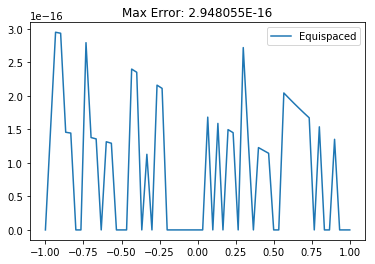

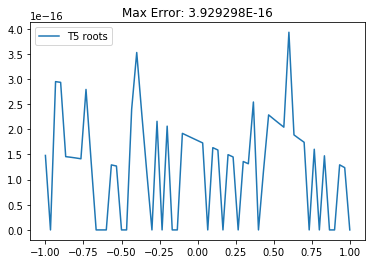

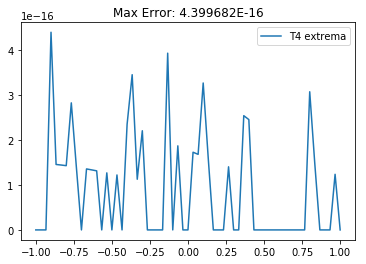

In [82]:
import numpy as np
import numpy.polynomial.chebyshev as cheb

nodes1 = np.linspace(-1,1,5) #domains includes -1 and +1 with 5 eqi-spaced nodes

nodes2 = cheb.chebroots((0, 0, 0, 0, 0, 1))  #returns the roots of T5

x2 = np.linspace(-1,1,61)  #setting up coarser domain to find the maxima/minima of T4

val_cheb_4 = cheb.chebval(x2,[0, 0, 0, 0, 1])  #computing T4
mask = np.zeros(len(x2))
nodes3 = np.zeros(5)   #array for storing the x's corresponding to extremas of T4
for i in range(5):
    max_ind = np.argmax(np.abs(val_cheb_4))
    mask[max_ind] = 1
    val_cheb_4 = np.ma.array(val_cheb_4, mask = mask)  #successively masking the extremas in descending order
    nodes3[i] = x2[max_ind]  #storing the corresponding x values

p = np.poly1d([1,2,3,4,5])  #the polynomial f(x) = x^4 + 2x^3 + 3x^2 + 4x + 5

#Setting up the instances for the different set of nodes 

b1 = BaryInterp(nodes1,p(nodes1))  #equispaced

b2 = BaryInterp(nodes2,p(nodes2))  #T5 nodes

b3 = BaryInterp(nodes3,p(nodes3))  #T4 extremas

err1 = np.abs((p(x2) - b1.interp_lagrange(x2))/p(x2))
err2 = np.abs((p(x2) - b2.interp_lagrange(x2))/p(x2))
err3 = np.abs((p(x2) - b3.interp_lagrange(x2))/p(x2))

#Plotting the relative errors for each case

plt.plot(x2, err1, label='Equispaced')
plt.title('Max Error: %E'%np.amax(err1))
plt.legend()

plt.figure()
plt.plot(x2, err2, label='T5 roots')
plt.title('Max Error: %E'%np.amax(err2))
plt.legend()

plt.figure()
plt.plot(x2, err3, label='T4 extrema')
plt.title('Max Error: %E'%np.amax(err3))

plt.legend()

**Looking at the actual interpolations**

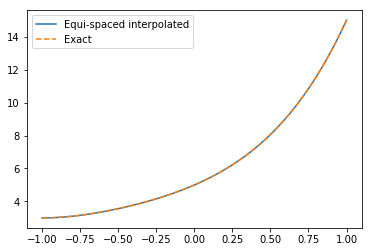

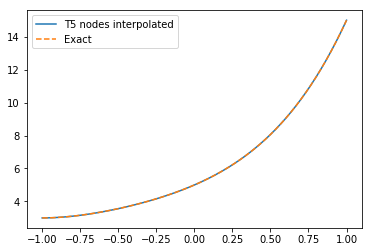

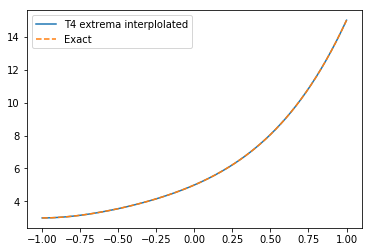

In [83]:
plt.plot(x2, b1.interp_lagrange(x2), label='Equi-spaced interpolated')
plt.plot(x2, p(x2),'--',label='Exact')
plt.legend()

plt.figure()
plt.plot(x2, b2.interp_lagrange(x2), label='T5 nodes interpolated')
plt.plot(x2, p(x2),'--',label='Exact')
plt.legend()

plt.figure()
plt.plot(x2, b3.interp_lagrange(x2), label='T4 extrema interplolated')
plt.plot(x2, p(x2),'--',label='Exact')

plt.legend()